In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
sns.set_theme(style='white', context='notebook', font_scale=1.33)

## Section 1: Summarize data

#### 1.1 Load and prepare data

In [2]:
## Load and prepare data.
data = read_csv(os.path.join('data', 'data.csv'))

## Apply rejections.
reject = read_csv(os.path.join('data', 'reject.csv'))
data = data.loc[data.subject.isin(reject.query('reject==0').subject)]

## Handle incomplete responses.
data['missing'] = data.accuracy.isnull().astype(int)
data['accuracy'] = data.accuracy.fillna(0)
data['rt'] = data.rt.fillna(30)

## Format data.
data['logrt'] = np.log(data.rt)

#### 1.2 Summarize data

In [3]:
## Summarize dataset.
print('Summary')
print('N trial = %s' %data.shape[0])
print('N subj  = %s' %data.subject.nunique())
print('N item  = %s' %data.item.nunique())

## Quality metrics.
print('\nQuality')
print('Missing: %0.2f%%' %(data.missing.mean() * 100))
print('Rapid:   %0.2f%%' %((data.rt < 3).mean() * 100))

Summary
N trial = 24016
N subj  = 1501
N item  = 64

Quality
Missing: 1.75%
Rapid:   1.08%


## Section 2: Item Sampling

#### 2.1 Available data by item

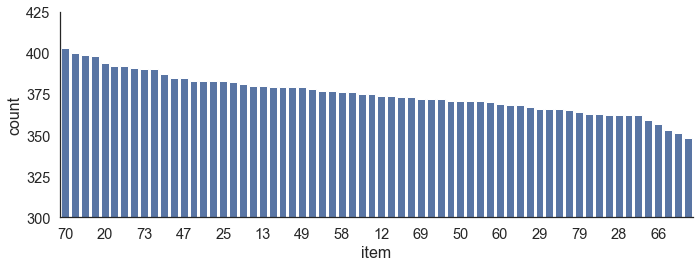

In [4]:
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(10,4))
order = data.item.value_counts().sort_values(ascending=False).index

## Plot counts.
sns.countplot(x='item', data=data, order=order, color='#4c72b0', ax=ax);

## Add detail.
ax.set(xticks=np.arange(0,64,4), xticklabels=order[::4], ylim=(300), yticks=np.arange(300,450,25))

sns.despine()
plt.tight_layout()

#### 2.2 Available data by test form

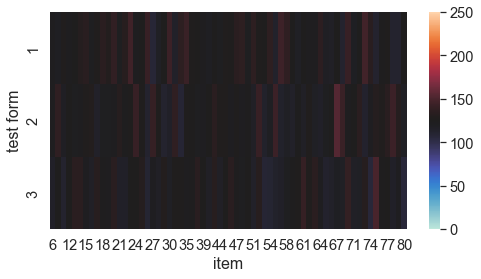

In [5]:
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(8,4))

## Compute counts.
pivot = data.pivot_table('trial', 'test_form', 'item', aggfunc='count')

## Plot counts.
center = (data.subject.nunique() * 16) / (data.item.nunique() * data.test_form.nunique())
sns.heatmap(pivot, vmin=0, vmax=center*2, center=center, ax=ax);

## Add detail.
ax.set(ylabel='test form');

#### 2.3 Available data by shape set

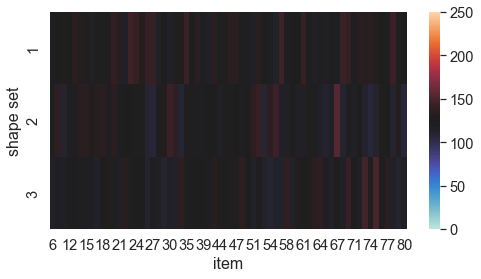

In [6]:
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(8,4))

## Compute counts.
pivot = data.pivot_table('trial', 'shape_set', 'item', aggfunc='count')

## Plot counts.
center = (data.subject.nunique() * 16) / (data.item.nunique() * data.shape_set.nunique())
sns.heatmap(pivot, vmin=0, vmax=center*2, center=center, ax=ax);

## Add detail.
ax.set(ylabel='shape set');

#### 2.4 Available data by distractor type

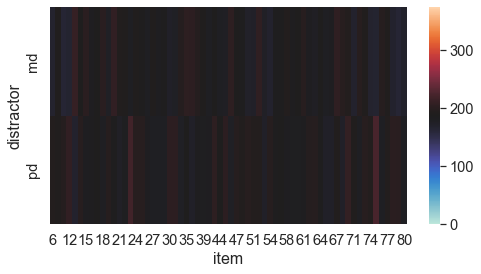

In [7]:
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(8,4))

## Compute counts.
pivot = data.pivot_table('trial', 'distractor', 'item', aggfunc='count')

## Plot counts.
center = (data.subject.nunique() * 16) / (data.item.nunique() * data.distractor.nunique())
sns.heatmap(pivot, vmin=0, vmax=center*2, center=center, ax=ax);

## Add detail.
ax.set(ylabel='distractor');

#### 2.5 Parwise item observations

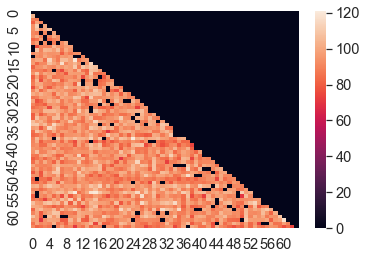

In [8]:
from itertools import combinations

## Preallocate space.
n_item = data.item.nunique()
counts = np.zeros((n_item,n_item))
data['id'] = np.unique(data.item, return_inverse=True)[-1]

## Compute pairwise counts.
for subject in data.subject.unique():

    ## Extract item set.
    items = np.unique(data.query(f'subject == "{subject}"').id)
    
    ## Iteratively tally.
    for i, j in combinations(items, 2): counts[j,i] += 1
        
## Plot paired observations.
sns.heatmap(counts);

## Section 3: Behavior

#### 3.1 Item accuracy

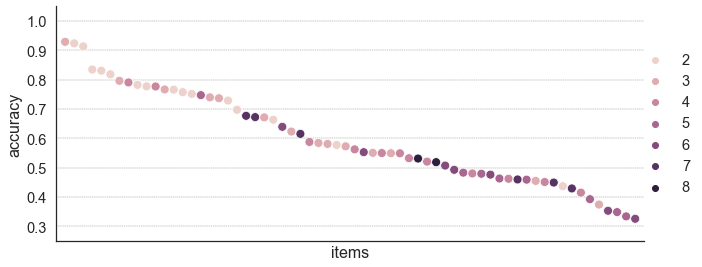

In [9]:
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(10,4))

## Compute summary statistics.
gb = data.groupby('item').agg({'subject':'count','accuracy':'mean','dimension':'mean'})
gb = gb.loc[gb.accuracy.sort_values(ascending=False).index]
n_item = gb.shape[0]

## Plot accuracy.
sns.scatterplot(x=np.arange(n_item), y=gb.accuracy, hue=gb.dimension, data=gb, s=80, ax=ax)
ax.grid(axis='y', color='0.5', lw=0.4, linestyle='--', zorder=-1)

## Add details.
ax.set(xlim=(-1, n_item), xticks=[], xlabel='items', ylim=(0.25,1.05), ylabel='accuracy')
ax.legend(loc=7, bbox_to_anchor=(1.1,0.5), frameon=False)

sns.despine()
plt.tight_layout()

#### 3.2 Accuracy by dimension

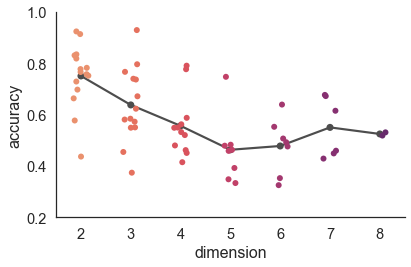

In [10]:
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(6,4))
palette = sns.color_palette('flare', n_colors=data.dimension.nunique())

## Compute item accuracy by test form.
gb = data.groupby(['item','dimension']).accuracy.mean().reset_index()

## Plot accuracy.
sns.pointplot(x='dimension', y='accuracy', data=gb, color='0.3', scale=0.8, ci=None, zorder=-1, ax=ax)
sns.stripplot(x='dimension', y='accuracy', data=gb, palette=palette, size=6, jitter=0.15, ax=ax)

## Add detail.
ax.set(xlabel='dimension', ylim=(0.2,1), ylabel='accuracy')

sns.despine()
plt.tight_layout()

#### 3.3 Accuracy by test form

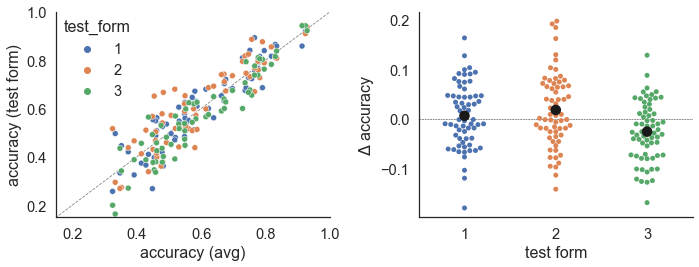

In [11]:
## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(10,4))
palette = sns.color_palette(n_colors=3)

## Compute item accuracy by shape set.
gb = data.pivot_table('accuracy','item','test_form')
gb['x'] = data.groupby('item').accuracy.mean()
gb = gb.melt(id_vars='x', value_name='accuracy')
gb['delta'] = gb['accuracy'] - gb['x']

## Plot accuracy.
sns.scatterplot(x='x', y='accuracy', hue='test_form', data=gb, palette=palette, ax=axes[0])
axes[0].plot([0,1], [0,1], lw=0.8, color='0.5', linestyle='--', zorder=-1)
axes[0].set(xlim=(0.15,1.0), xlabel='accuracy (avg)', ylim=(0.15,1.0), ylabel='accuracy (test form)')
axes[0].legend(loc=2, frameon=False, borderpad=0, title='test_form')

## Plot accuracy.
sns.swarmplot(x='test_form', y='delta', data=gb, zorder=-1, ax=axes[1])
sns.pointplot(x='test_form', y='delta', data=gb, scale=1.2, color='k', join=False, ci=None, ax=axes[1])
axes[1].axhline(0, color='k', lw=0.5, linestyle='--', zorder=-2)
axes[1].set(xlabel='test form', ylabel=r'$\Delta$ accuracy')

sns.despine()
plt.tight_layout()

#### 3.4 Accuracy by shape set

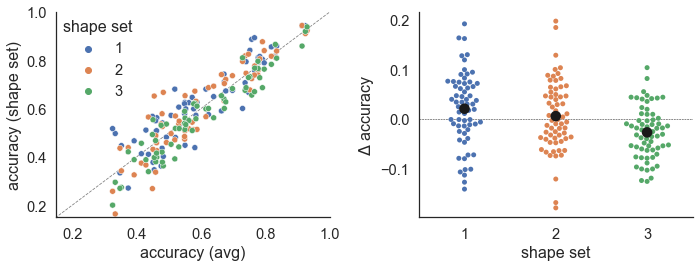

In [12]:
## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(10,4))
palette = sns.color_palette(n_colors=3)

## Compute item accuracy by shape set.
gb = data.pivot_table('accuracy','item','shape_set')
gb['x'] = data.groupby('item').accuracy.mean()
gb = gb.melt(id_vars='x', value_name='accuracy')
gb['delta'] = gb['accuracy'] - gb['x']

## Plot accuracy.
sns.scatterplot(x='x', y='accuracy', hue='shape_set', data=gb, palette=palette, ax=axes[0])
axes[0].plot([0,1], [0,1], lw=0.8, color='0.5', linestyle='--', zorder=-1)
axes[0].set(xlim=(0.15,1.0), xlabel='accuracy (avg)', ylim=(0.15,1.0), ylabel='accuracy (shape set)')
axes[0].legend(loc=2, frameon=False, borderpad=0, title='shape set')

## Plot accuracy.
sns.swarmplot(x='shape_set', y='delta', data=gb, zorder=-1, ax=axes[1])
sns.pointplot(x='shape_set', y='delta', data=gb, scale=1.2, color='k', join=False, ci=None, ax=axes[1])
axes[1].axhline(0, color='k', lw=0.5, linestyle='--', zorder=-2)
axes[1].set(xlabel='shape set', ylabel=r'$\Delta$ accuracy')

sns.despine()
plt.tight_layout()

#### 3.5 Accuracy by distractor

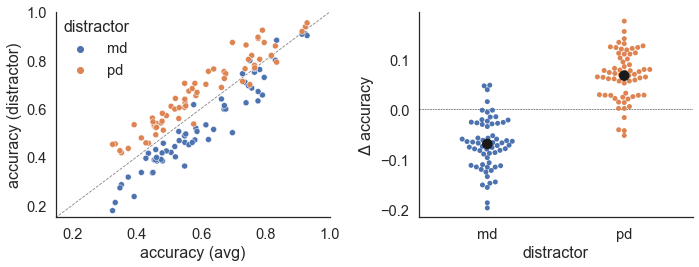

In [13]:
## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(10,4))
palette = sns.color_palette(n_colors=2)

## Compute item accuracy by test form.
gb = data.pivot_table('accuracy', 'item', 'distractor')
gb['x'] = data.groupby('item').accuracy.mean()
gb = gb.melt(id_vars='x', value_name='accuracy')
gb['delta'] = gb['accuracy'] - gb['x']

## Plot accuracy.
sns.scatterplot(x='x', y='accuracy', hue='distractor', data=gb, palette=palette, ax=axes[0])
axes[0].plot([0,1], [0,1], lw=0.8, color='0.5', linestyle='--', zorder=-1)
axes[0].set(xlim=(0.15,1.0), xlabel='accuracy (avg)', ylim=(0.15,1.0), ylabel='accuracy (distractor)')
axes[0].legend(loc=2, frameon=False, borderpad=0, title='distractor')

## Plot accuracy.
sns.swarmplot(x='distractor', y='delta', data=gb, zorder=-1, ax=axes[1])
sns.pointplot(x='distractor', y='delta', data=gb, scale=1.2, color='k', join=False, ci=None, ax=axes[1])
axes[1].axhline(0, color='k', lw=0.5, linestyle='--', zorder=-2)
axes[1].set(xlabel='distractor', ylabel=r'$\Delta$ accuracy')

sns.despine()
plt.tight_layout()

#### 3.6 Accuracy by RT

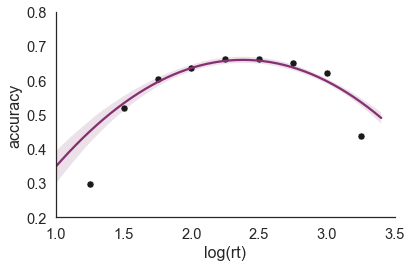

In [14]:
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(6,4))

## Digitize RTs.
data['drt'] = np.digitize(data.logrt, np.arange(1.5, 3.5, 0.25))
data['drt'] = data.drt.replace({i:j for i, j in enumerate(np.arange(1.25,3.50,0.25))})

## Compute average accuracy by binned RT.
gb = data.groupby(['drt']).accuracy.mean().reset_index()

## Plot accuracy ~ logrt polynomial regression.
sns.regplot(x='logrt', y='accuracy', data=data, color='#863071', order=2, scatter=False, ax=ax)

## Plot observations.
sns.scatterplot(x='drt', y='accuracy', data=gb, s=50, color='k', ax=ax)

## Add detail.
ax.axhline(0, color='0.5', lw=0.5, linestyle='--', zorder=-1)
ax.set(xlim=(1, 3.5), xlabel='log(rt)', ylim=(0.2,0.8))

sns.despine()
plt.tight_layout()

#### 3.7 Rapid guessing by trial number

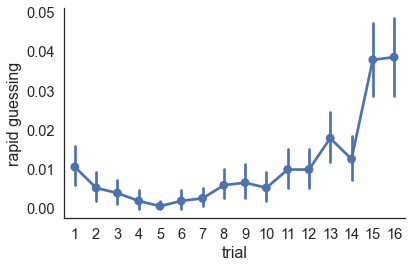

In [15]:
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(6,4))

## Identify rapid guessing.
data['rg'] = np.where(data['rt'] < 3, 1, 0)

## Plot rapid guessing.
sns.pointplot(x='trial', y='rg', data=data, ax=ax)

## Add detail.
ax.set(xlabel='trial', ylabel='rapid guessing')

sns.despine()
plt.tight_layout()

## Section 4: Demographics

#### 4.1 Load and prepare data

In [16]:
## Load and prepare data.
metadata = read_csv(os.path.join('data', 'metadata.tsv'), sep='\t')

## Format data.
metadata = metadata.rename(columns={'gender-categorical':'gender'})
metadata = metadata.replace({'Associate degree':'Some college',
                             'Less than high school':'High school'})

## Apply rejections.
reject = read_csv(os.path.join('data', 'reject.csv'))
metadata = metadata.loc[metadata.subject.isin(reject.query('reject==0').subject)]

## Merge with data.
data = data.merge(metadata[['subject','age','gender','education']], on='subject')

#### 4.2 Gender / age composition

                count  mean   std   min   25%   50%   75%   max
gender                                                         
Female          811.0  27.7   9.6  18.0  21.0  24.0  32.0  74.0
Male            670.0  30.1  10.1  18.0  22.0  28.0  36.0  70.0
Other            13.0  26.3   4.8  19.0  23.0  27.0  30.0  35.0
Rather not say    2.0  22.0   2.8  20.0  21.0  22.0  23.0  24.0


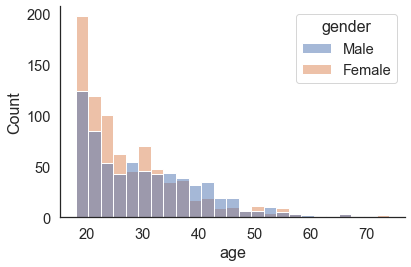

In [17]:
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(6,4))

## Print gender / age composition.
print(metadata.groupby('gender').age.describe().round(1))

## Plot gender / age composition.
sns.histplot(x='age', hue='gender', data=metadata, hue_order=['Male','Female'], ax=ax)

sns.despine()
plt.tight_layout()

#### 4.3 Education

education,Bachelor degree,High school,Master degree or higher,Rather not say,Some college
gender,,,,,
Female,310,109,115,2,275
Male,192,89,207,0,187
Other,5,0,0,0,8
Rather not say,0,1,0,0,1


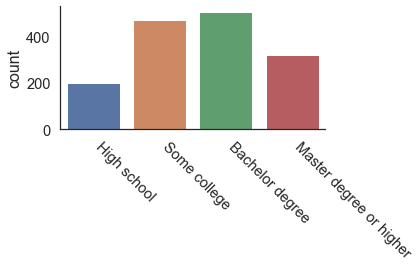

In [18]:
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(6,4))
order = ['High school', 'Some college', 'Bachelor degree', 'Master degree or higher']

## Plot gender / age composition.
sns.countplot(x='education', data=metadata, order=order, ax=ax)

## Add detail.
ax.set(xlabel='')
ax.set_xticklabels(order, rotation=-45, ha='left')

sns.despine()
plt.tight_layout()

metadata.pivot_table('subject','gender','education',aggfunc='count').fillna(0).astype(int)

#### 4.4 Accuracy by demographics

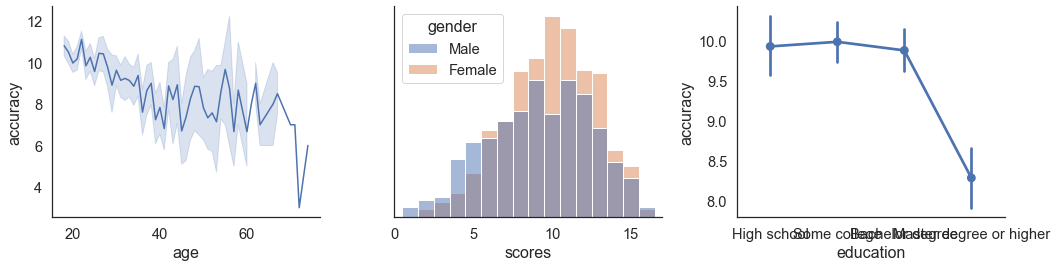

In [19]:
## Initialize canvas.
fig, axes = plt.subplots(1,3,figsize=(15,4))

## Plot accuracy by age.
gb = data.groupby(['age','subject']).accuracy.sum().reset_index()
sns.lineplot(x='age', y='accuracy', data=gb, ax=axes[0])

## Plot accuracy by gender. 
gb = data.groupby(['gender','subject']).accuracy.sum().reset_index()
sns.histplot(x='accuracy', hue='gender', data=gb, bins=np.arange(-0.5,17),
             hue_order=['Male','Female'], stat='probability', ax=axes[1])
axes[1].set(xlim=(0,17), xlabel='scores', ylabel='', yticks=[])

## Plot accuracy by education. 
gb = data.groupby(['education','subject']).accuracy.sum().reset_index()
sns.pointplot(x='education', y='accuracy', data=gb, order=order, ax=axes[2])

sns.despine()
plt.tight_layout()

## Section 5: Consistency

#### 5.1 Item accuracy

In [20]:
## Load and prepare original data summary.
stats = read_csv(os.path.join('data','stats.csv'))
stats = stats.query('Group=="total" and N >= 200')
stats = stats[['Item','Mean.correct']].rename(columns={'Item':'item','Mean.correct':'correct'})

## Compute accuracy by item.
gb = data.groupby('item').accuracy.mean().reset_index()
gb = gb.merge(stats, on='item')

## Compute consistency.
gb[['correct','accuracy']].corr(method='spearman')

,correct,accuracy
correct,1.000000,0.870453
accuracy,0.870453,1.000000
